Cameron Wood <br>
DTSA 5510 Final Project

GitHub Repo: https://github.com/cameronwood7/EMNIST-Unsupervised.git

### **Project Rundown**

The EMNIST (Extended Modified National Institute of Standards and Technology) Letters Dataset is an extension of the well-known MNIST dataset, which is the bread and butter of machine learning benchmarking. What sets EMNIST apart is its larger size and, as the name suggests, its inclusion of handwritten letters. This project will focus on the letter component within this extended dataset. </br>

Image processing often relies on deep learning, which is CPU and GPU intensive. Through Unsupervised and Supervised Learning, this project will show how we can create robust Classification models for handwritten letters. These models are more efficient and can be used on everyday machines, which would make them more accessible and useful for a broader audience. 

### **Data Description**

The EMNIST Dataset was derived from the NIST Special Database 19 and converted to the same format and structure as the MNIST dataset. The original NIST Special Database 19 was currated from 3600 writers, consists of 810,000 character images and their respective true labels. </br>

More details about the collection and conversion process is described in *EMNIST: an extension of MNIST to handwritten letters* by Gregory Cohen, et al. The data itself can be found within the paper referenced. </br>

In the EMNIST Letters dataset, there are 88,800 samples in 26 classes representing every letter in the alphabet, upper- and lower-case. The data is stored in a binary format that describes the image in terms of 8-bit gray-scale resolution. All images are 28x28 pixels in size. </br>

#### References: </br>
Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373 </br>


### **Data Cleaning**

First we can run the cell below to get all of the necessary packages.

In [89]:
# Importing Packages

import math
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Importing all necessary libraries

import itertools
from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import uniform

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

And then we can load in the data and check out what we're working with. We'll want to take note that the test dataset does not contain all of the letters in the alphabet, so we will just be using the training dataset and splitting it.

In [31]:
# Loading in the Dataset
data = pd.read_csv('emnist-letters-train.csv')

In [32]:
# Showing Data header
data.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It looks like our column header for our 'labels' is named '23' in the data, so we can fix that for data set. This will make it easier to reference later on in the code. </b>

We also notice that the labels are listed as integers 1-26 representing the entire alphabet. We will maintain this labeling method for ease of use.

In [33]:
#Renaming Labels Column
data = data.rename({'23':'labels'}, axis='columns')

data = data[:10000]

# We'll also want to rename all the pixel columns to be representative of that

count = 0

for i in data.columns:
    if (i != 'labels'):
        newName = 'pixel' + str(count)
        data = data.rename({i:newName}, axis='columns')
        count += 1

In [34]:
#Checking the training data
data.head()

,labels,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we'll want to check for any null values, and to make sure that the data types align with what we're expecting. This is so our models don't break down the line.

In [35]:
# Checking for Null Values
NullVal = data.isnull().sum()
print("For Train Data: ")
print(NullVal[NullVal != 0])

For Train Data: 
Series([], dtype: int64)


In [36]:
# Checking Data Types for the Data
print("Train Data: ")
print(data.info())

Train Data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, labels to pixel783
dtypes: int64(785)
memory usage: 59.9 MB
None


Lastly, we'll want to ensure that our pixel values contain intensity values, and that our training data has all 26 letters in it.

        pixel0   pixel1   pixel2   pixel3        pixel4        pixel5  \
count  10000.0  10000.0  10000.0  10000.0  10000.000000  10000.000000   
mean       0.0      0.0      0.0      0.0      0.006400      0.035400   
std        0.0      0.0      0.0      0.0      0.452526      2.497673   
min        0.0      0.0      0.0      0.0      0.000000      0.000000   
25%        0.0      0.0      0.0      0.0      0.000000      0.000000   
50%        0.0      0.0      0.0      0.0      0.000000      0.000000   
75%        0.0      0.0      0.0      0.0      0.000000      0.000000   
max        0.0      0.0      0.0      0.0     32.000000    183.000000   

             pixel6        pixel7        pixel8        pixel9  ...  pixel774  \
count  10000.000000  10000.000000  10000.000000  10000.000000  ...   10000.0   
mean       0.033500      0.041100      0.031500      0.007600  ...       0.0   
std        2.397614      2.678195      2.338986      0.544033  ...       0.0   
min        0.000000   

Text(0.5, 1.0, 'Histogram of EMNIST Data Set')

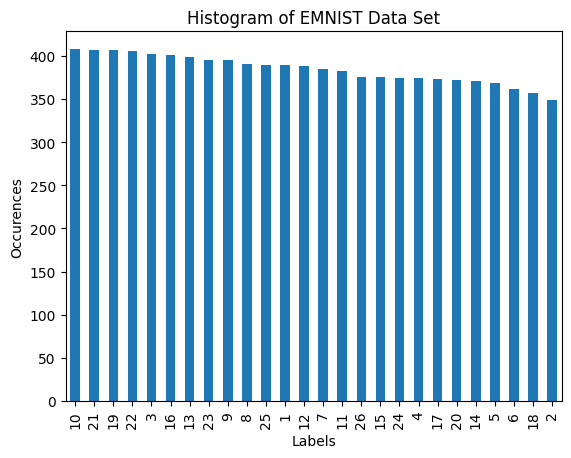

In [37]:
# For the training data
print(data.iloc[:, 1:].describe())

# Add Labels
ax = data['labels'].value_counts().plot(kind='bar')
ax.set_xlabel('Labels')
ax.set_ylabel('Occurences')
ax.set_title('Histogram of EMNIST Data Set')

Now that we have common column headers across both our dataset, we can now begin to work with the data in a meaningful way. EMNIST is a newer and less used dataset compared to MNIST, so it isn't as clean. We also confirmed that there are no null values within the dataset, and it consists of all integer values so we won't have any issues building our classification models. </br>

We also ensured that for the training and testing data sets have real intensity values in their pixels. We also ensured that there is an even distribution of letters within the data set, meaning we shouldn't have any bias towards a particular letter being trained on more significantly than any others. </br>

### **Exploratory Data Analysis**

Starting off we can split up our dataset into X, being our intensity values per pixel, and y, our labels. We'll also want to create an "alphabet" array to reference when accessing our labels.

In [38]:
# Seperating data from lables
X = data.drop('labels', axis=1).values
y = data['labels'].values

In [39]:
# Creating array of the alphabet
alphabet = []
for i in range(26):
    letter = chr(ord('a') + i)
    alphabet.append(letter)

Now we can use these new arrays to try plotting an example of what these handwritten letters look like. The images are flipped and rotated, so this is corrected in plotting. This fact won't change the classification models, since they are all in the same orientation.

In [40]:
# Method to view the letters at a specified index
def view_letter(data, label=None):
    fig = plt.figure(figsize=(3,3))
    data = np.flipud(data.reshape(28,28))
    data = np.rot90(data)
    data = np.rot90(data)
    data = np.rot90(data)
    plt.imshow(data, cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("True: {}".format(label), fontsize=16) 

In the cell below we can play with the index value and show a letter with it's true label.

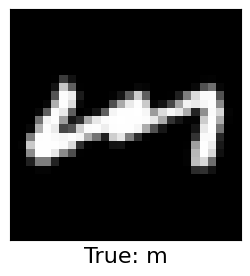

In [41]:
# Specify an index within the dataset and plot, along with specifying its true label
index = 5

view_letter(X[index], label=alphabet[y[index]-1])

Aside from the histogram showing the frequency of letters that show up in the dataset, found in the Data Cleaning section, we can also plot the intensities found across the dataset per letter.

Text(0.5, 1.0, 'Average Intensity Across EMNIST Dataset')

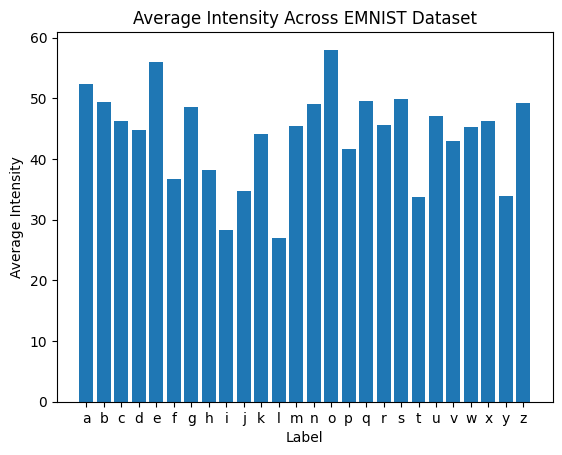

In [42]:
# Initialize arrays to store intensity values and counts
avg_intensity = np.zeros(26)
counts = np.zeros(26)

# Loop through X and gather information. Exlude intensity values of 0 which are black pixels

for i in range(len(X)):
    counts[y[i]-1] += 1
    avg_intensity[y[i]-1] += np.mean(X[i])

avg_intensity /= counts

# Plot a histogram of the intensity values

plt.bar(alphabet, avg_intensity)
plt.xlabel('Label')
plt.ylabel('Average Intensity')
plt.title('Average Intensity Across EMNIST Dataset')


We can see that there is quite a bit of variability in intensity between letters, but that is generally due to the size and shape of the letter written. For example, the letter i takes up significantly less space than something like a so the intensity is lower due to there being many more black pixels. </br>

Something else we can look at is the distribution of intensities across a particular letter. For this example I'll use the letter 'z' and compare it to 'o'.

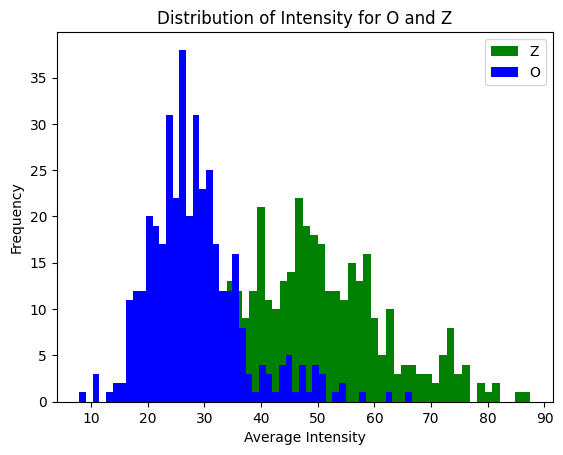

In [43]:
# Initialize Arrays
avg_intensity_z = []
avg_intensity_o = []

# Loop through the length and X and pick out any intensities that are Z or O
for i in range(len(X)):
    if y[i] == 26:
        avg_intensity_z.append(np.mean(X[i]))

    if y[i] == 9:
        avg_intensity_o.append(np.mean(X[i]))

# Plot the distribution of intensities                         
plt.hist(avg_intensity_z, bins=50, color='green', label='Z')
plt.hist(avg_intensity_o, bins=50, color='blue', label='O')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity for O and Z')
plt.legend()

As one might expect, there is higher variability in how someone might write the z versus how someone might write the letter o. The purpose of showing these distributions also helps to show feature seperability, which will allow us to better classify the letters.

In conclusion, we have found that our dataset contains proper distribution of letters so we don't introduce any training bias towards any particular letter. We were also able to take a look at what the images look like, along with the distribution of their features (intensity values). </br>

As expected, smaller and small letters, like i and l will have lower intensity values than larger letters like o and z. We were also able to compare the distribution of intensities for the letters o and z to show variability. A simple letter like o has less variation in how people write it, versus something like z. Depending on the models you are interested in using, this feature seperability can help in classification. It's also important to note that these distributions follow a mostly normal distribution, meaning that the data set is truly random with differing variability. </br>

As we move onto our models, there are forseen challenges with respect to this dataset. For some letters, as mentioned in the Project Rundown, we see both upper- and lower-case letters. This will increase variability, and make it harder for our basic classifiers to find common features between the two.

### **Models**

To start off, we'll split our data into training and testing sets. For our purposes we'll use a test size of 20%. </br>

It should be noted that due to the random nature of our letters chosen, and all images independent of one another, there is no collinearity between the data and this will not be an issue with the following models.

In [44]:
# Split the data into train and test sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#### **Clustering**

Clustering is a great unsupervised learning method for categorizing large data sets. They often allow us to discover hidden insights and structures within the data that isn't immediately apparent. In the case for EMNIST, we can surmise that letters like "l" and "i" will get clustered together due to their similar shapes, which may be these models' downfalls.

For our testing, we'll be using Agglomerative Clustering and K-Means Clustering. Agglomerative Clustering can allow us to see the underlying relationships between data points using its heirarchical structure, while K-Means is better at handiling higher dimensional datasets even if both suffer from "the curse of dimensionality."

**Agglomerative Clustering**

In [45]:
# Set up the function to collect the cluster labels, as they will be randomized

def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
        
    return reference_labels

First we'll set up a way to optimize our model for certain parameters. We'll loop through the number of clusters, affinity, and linkage method. Then we'll store off the best model, accuracy, and combination.

In [46]:
n_clusters = [26, 52, 104, 260, 650]
affinity = ['euclidean', 'manhattan']
linkage = ['ward','complete','average','single']

model = None
maxAcc = 0.0
bestComb = {}
bestCfmx = None
bestModel = None

for n_clust, aff, link in itertools.product(n_clusters, affinity, linkage):
    try:
        model = AgglomerativeClustering(n_clusters = n_clust, affinity = aff, linkage = link)
        labels = model.fit_predict(X_train)
        reference_labels = retrieve_info(labels, y_train)
        letter_labels = np.random.rand(len(labels))
        for i in range(len(labels)):
            letter_labels[i] = reference_labels[labels[i]]  

        acc = accuracy_score(letter_labels, y_train)

        if acc > maxAcc:
            maxAcc = acc
            bestCfmx = confusion_matrix(letter_labels,y_train)
            bestComb = {'n_clusters': n_clust, 'affinity': aff, 'linkage': link}
            bestModel = model
   
    except:
        print("Failed Combination")


Failed Combination
Failed Combination
Failed Combination
Failed Combination
Failed Combination


In [82]:
print(bestComb)

{'n_clusters': 650, 'affinity': 'euclidean', 'linkage': 'ward'}


**K-Means Clustering**

Now we'll set up a way to optimize our model for number of clusters along with the distance algorithm. The Lloyd algorithm is the default and minimizes the within-cluster sum of squares, while the Elkan method reduces the computational complexity of the algorithm. 

In [48]:
n_clusters = [26, 52, 104, 260, 650]
alg = ['lloyd','elkan']

model = None
KmaxAcc = 0.0
KbestComb = {}
KbestCfmx = None
KbestModel = None

for n_clust, alg in itertools.product(n_clusters, alg):
    try:
        model = KMeans(n_clusters = n_clust, algorithm=alg, random_state=42)
        labels = model.fit_predict(X_train)
        reference_labels = retrieve_info(labels, y_train)
        letter_labels = np.random.rand(len(labels))
        for i in range(len(labels)):
            letter_labels[i] = reference_labels[labels[i]]  

        acc = accuracy_score(letter_labels, y_train)

        if acc > KmaxAcc:
            KmaxAcc = acc
            KbestCfmx = confusion_matrix(letter_labels,y_train)
            KbestComb = {'n_clusters': n_clust, 'algorithm': alg}
            KbestModel = model
    except:
        print("Failed Combination")

In [83]:
print(KbestComb)

{'n_clusters': 650, 'algorithm': 'lloyd'}


##### **KNN**

K-Nearest Neighbors Classifiers are a great supervised learning model to use that is basic while also providing easily interpretable results. This will be good to test against the unsupervised clustering performance.

In [50]:
params = {
    'n_neighbors': [1, 2, 3, 4, 5], # Lower k-values typically do better, and saves on compute
    'weights': ['uniform', 'distance'], # We want to test whether weighting our neighbors helps performance
    'metric': ['euclidean'], # We'll maintain euclidean distance throughout
    'leaf_size': [5, 10, 15] # We'll manipulate our leaf size
}

# Now we can set up our Grid Search and train our model
KNN = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy')

KNN.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15], 'metric': ['euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [51]:
# Save off our best KNN Model
KNN_Best = KNN.best_estimator_

# And the best parameters are

print(KNN.best_params_)

{'leaf_size': 5, 'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}


### **Results and Analysis**

Now that we have multiple models, we can begin to compare the performance through multiple lenses. To guide this discussion, we can start off with Confusion Matricies for the Clustering and KNN models.

Text(0.5, 1.0, 'KNN Confusion Matrix')

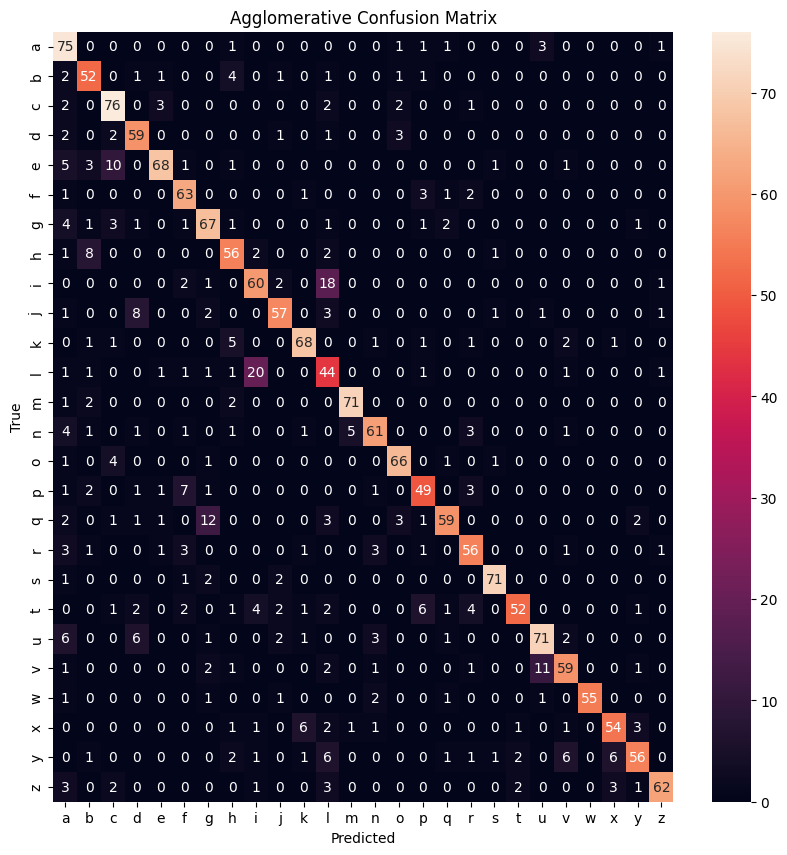

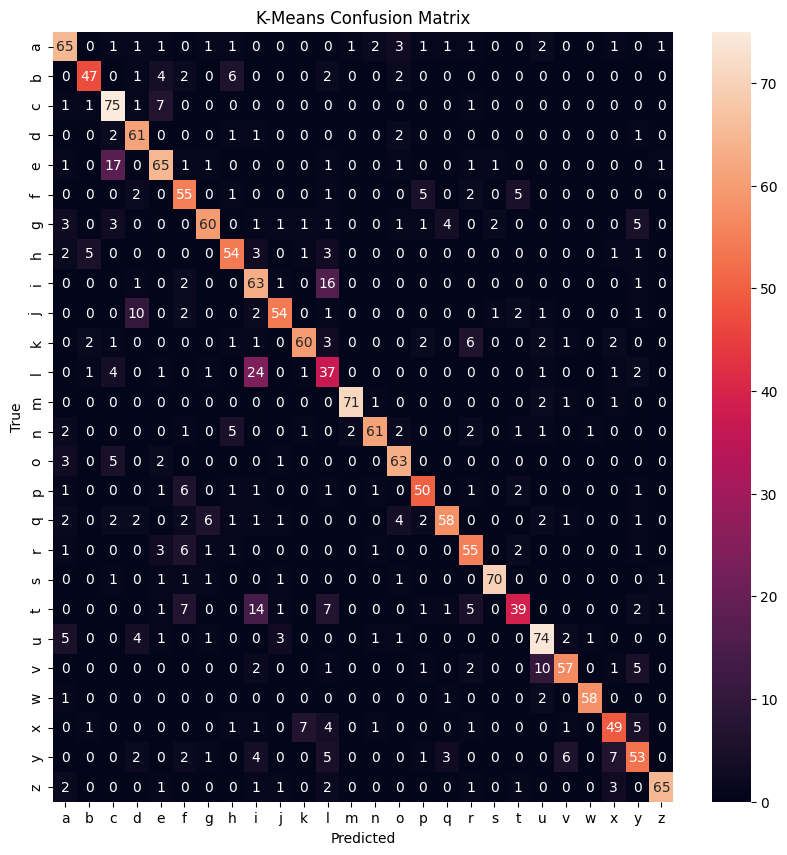

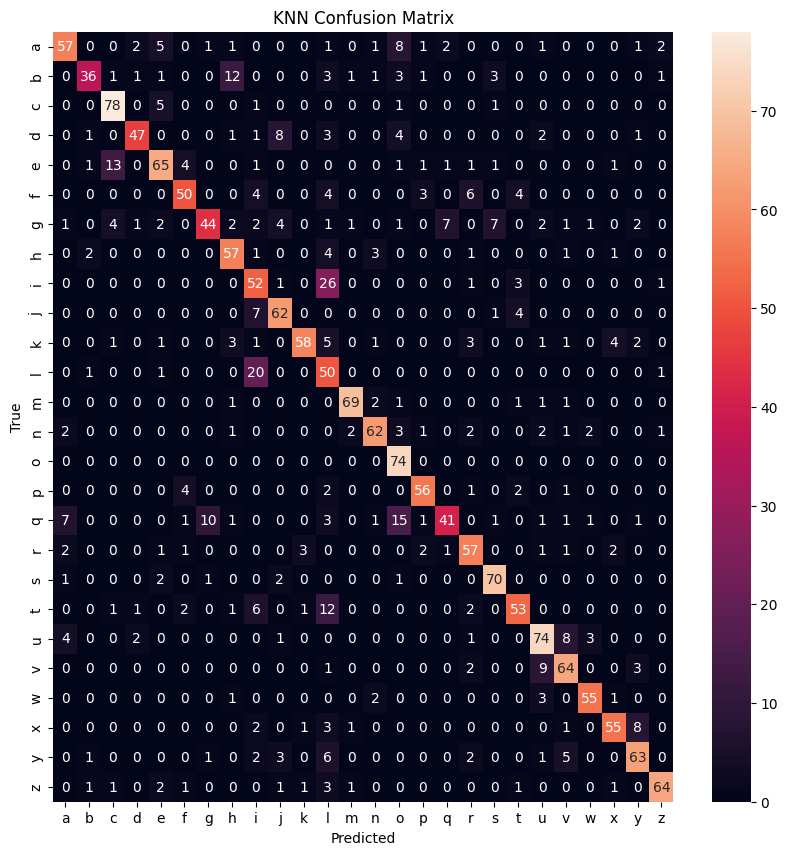

In [134]:
# First we can calculate the predictions
pred_Agg = bestModel.fit_predict(X_test)
pred_KMeans = KbestModel.fit_predict(X_test)
pred_KNN = KNN_Best.predict(X_test)

# We need to grab the labels for the unsupervised models
reference_labels_Agg = retrieve_info(pred_Agg, y_test)
Agg_labels = np.random.rand(len(pred_Agg))
for i in range(len(pred_Agg)):
    Agg_labels[i] = reference_labels_Agg[pred_Agg[i]]  

reference_labels_KMeans = retrieve_info(pred_KMeans, y_test)
kMeans_labels = np.random.rand(len(pred_KMeans))
for i in range(len(pred_KMeans)):
    kMeans_labels[i] = reference_labels_KMeans[pred_KMeans[i]]  


# Create the confusion matricies
cmAgg = confusion_matrix(y_test, Agg_labels)
cmKMeans = confusion_matrix(y_test, kMeans_labels)
cmKNN = confusion_matrix(y_test, pred_KNN)


# Plot the matricies as heat maps

# Agglomerative
ax1 = plt
ax1.figure(figsize=(10,10))
sns.heatmap(cmAgg, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax1.xlabel('Predicted')
ax1.ylabel('True')
ax1.title('Agglomerative Confusion Matrix')

# K-Means

ax2 = plt
ax2.figure(figsize=(10,10))
sns.heatmap(cmKMeans, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax2.xlabel('Predicted')
ax2.ylabel('True')
ax2.title('K-Means Confusion Matrix')

# KNN
ax3 = plt
ax3.figure(figsize=(10,10))
sns.heatmap(cmKNN, annot=True, xticklabels=alphabet, yticklabels=alphabet)
ax3.xlabel('Predicted')
ax3.ylabel('True')
ax3.title('KNN Confusion Matrix')



As one may have expected, we see misclassifications in letters that look similar in all models: i, t and l, c and e. In all of their lower-case forms, they all follow a similar geometry when it comes to writing making it difficult for basic classifiers such as these to distinguish them 100% of the time. </br>

Let's take a look at an example dendrogram for the Agglomerative Clustering to see where the confusion may come from. I used a small sub-set of data, so this may be skewed and heavily weighted towards mistakes.

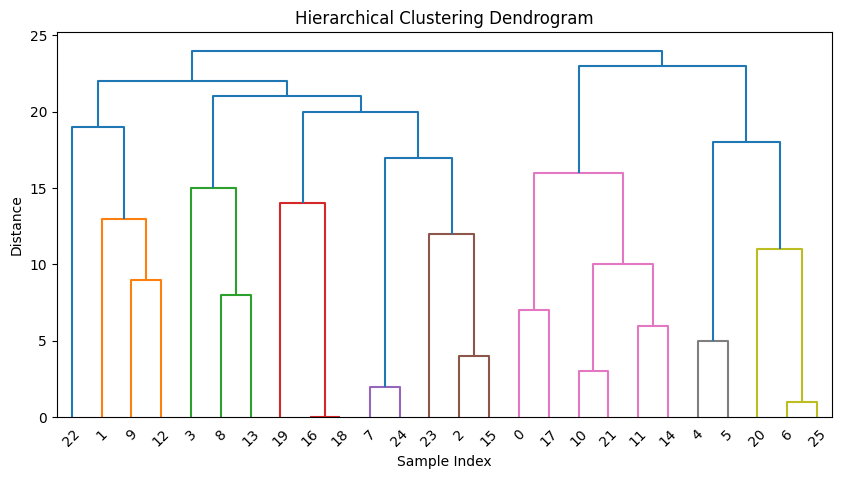

In [84]:
def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and plot dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(n_clusters = 26, affinity = 'euclidean', linkage = 'ward')
labels = model.fit_predict(X_train[:26])

plt.figure(figsize=(10, 5))
plot_dendrogram(model)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

We can go back to our view_letter function used before to see why these letters are linking together. Our closest linkage was between 16 and 18, which will correspond to the letters position in the training set.

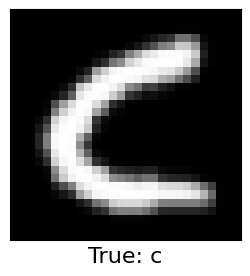

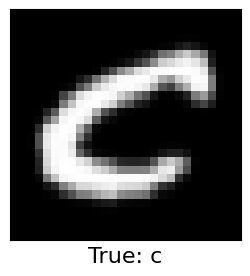

In [87]:
index1 = 16
index2 = 18

view_letter(X_train[index1], label=alphabet[y_train[index1]-1])

view_letter(X_train[index2], label=alphabet[y_train[index2]-1])

Lucky for us, and to show how well the model works, the letters are both 'c.' Now let's find two that aren't the same: items 6 and 25.

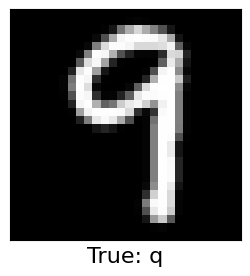

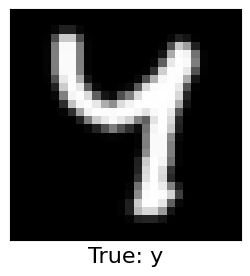

In [88]:
index1 = 6
index2 = 25

view_letter(X_train[index1], label=alphabet[y_train[index1]-1])

view_letter(X_train[index2], label=alphabet[y_train[index2]-1])

These letters have a short linakge, however they are not the same letter. As we can see, they are drawn very similarly, and due to the small sample size, it makes sense that they are grouped together. As we'll note in the final discussion, a common issue with clustering letters is due to the wide range of ways people write letters.

Now we can also look at a clustering map for the K-Means Clustering. Again, we'll use a downselected number of clusters to make the plot easy to interpret, and also use PCA to flatten our images to two dimensions so we can plot the clusters.

<Figure size 800x600 with 0 Axes>

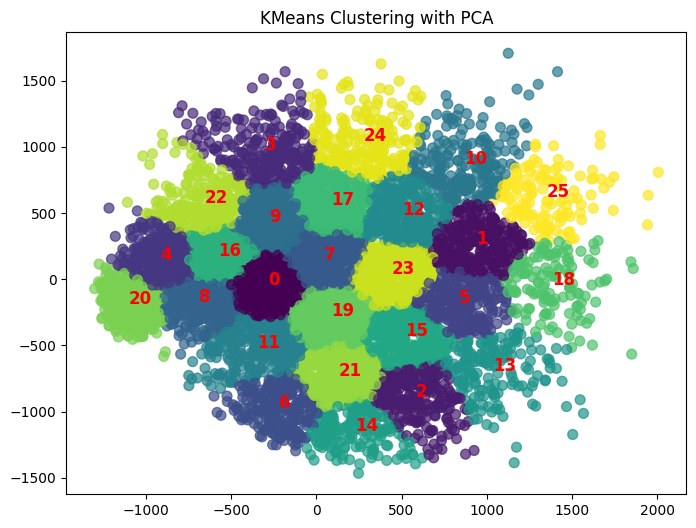

In [118]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

kmeans = KMeans(n_clusters=26, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
for i, center in enumerate(kmeans.cluster_centers_):
    plt.annotate(str(i), (center[0], center[1]), color='red', fontsize=12, fontweight='bold')
plt.title('KMeans Clustering with PCA')
plt.show()

We can do something similar with the Agglomerative Clustering, and look at a specific cluster and see what letters are in each one. Let's check out cluster 6.

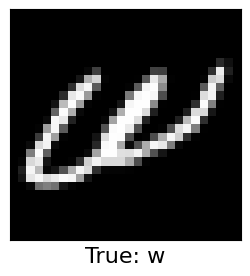

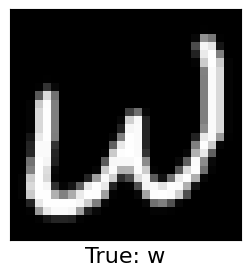

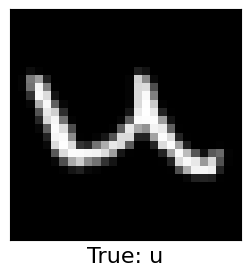

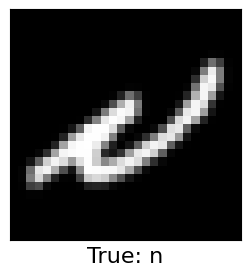

In [132]:
# Grab cluster data points

clusterDP = X_train[labels == 6]
trueLab = y_train[labels == 6]

# Now plot the first 5 letters

for i in range(20,24):
    view_letter(clusterDP[i], label=alphabet[trueLab[i]-1])

As we can see, the similarity between all of the letters is that they typically follow the shape of a 'w,' however we get letters like u or n that may be written sloppily. These are the types of hidden insights that come out with clustering. The cluster may not be that the letter is 'w' at all, but may have been chosen based on how squiggily the drawing is.

To get more granular, we will now look at the accuracy, precision, and recall for these models. Since this is a classification problem, we'll want to know how often we predicted correctly, how often our positive predictions were correct, and our models' abilities to correctly identify positive instances.

In [135]:
# Calculate Metrics for Agglomerative Clustering
prec_Agg = precision_score(y_test, Agg_labels, average=None)
rec_Agg = recall_score(y_test, Agg_labels, average=None)
acc_Agg = accuracy_score(y_test, Agg_labels, average=None)

# Calculate Metrics for K-Means Clustering
prec_KMeans = precision_score(y_test, kMeans_labels, average=None)
rec_KMeans = recall_score(y_test, kMeans_labels, average=None)
acc_KMeans = accuracy_score(y_test, kMeans_labels)

# Calculate Metrics for KNN_Best

prec_KNN = precision_score(y_test, pred_KNN, average=None)
rec_KNN = recall_score(y_test, pred_KNN, average=None)
acc_KNN = accuracy_score(y_test, pred_KNN)

# Print out Stats

print(" ")
print("Agglomerative Clustering Model Stats: ")
print("Accuracy: ")
print(acc_Agg)
print("Precision: ")
print(np.mean(prec_Agg))
print("Recall: ")
print(np.mean(rec_Agg))

print(" ")
print("K-Means Clustering Model Stats: ")
print("Accuracy: ")
print(acc_KMeans)
print("Precision: ")
print(np.mean(prec_KMeans))
print("Recall: ")
print(np.mean(rec_KMeans))

print(" ")
print("KNN Model Stats: ")
print("Accuracy: ")
print(acc_KNN)
print("Precision: ")
print(np.mean(prec_KNN))
print("Recall: ")
print(np.mean(rec_KNN))

 
Agglomerative Clustering Model Stats: 
Accuracy: 
0.7935
Precision: 
0.805353766968406
Recall: 
0.7953086556057897
 
K-Means Clustering Model Stats: 
Accuracy: 
0.7595
Precision: 
0.7740182601687542
Recall: 
0.761468170021083
 
KNN Model Stats: 
Accuracy: 
0.7565
Precision: 
0.776984973452488
Recall: 
0.7588921484213712


From these numbers, it's easy to see that our Agglomerative Clustering Model outperforms the K-Means and KNN models by about 4%. This may be due to Agglomerative Clustering being a heirarchial model that allows for uniquely shaped clusters, whereas K-Means tends to stick with spherical clusters. The dataset has a lot of uniquely written letters, and this spherical shape tends to be sensitive to outliers. Both of the clustering algorithms outperformed the KNN model, likely due to the high number of clusters used in both. This high number of unique clusters, having been 25 times that of the unique letters in the data set, allows for the model to account for unique shapes and sizes for each letter. 

In Summary, the Accuracy, Precision and Recall for Agglomerative Clustering was: 79%, 80% and 80%. The same values for K-Means Clustering was: 76%, 77%, and 76%. And lastly, the values for KNN was 76%, 78%, and 76%.

For a step further, we can look at the Precision and Recall against all 26 letters by comparing the test data on the two clustering models, and then again for the K-Means and KNN models as they performed very similarly. This may give us more insight into why we see almost a 5% improvement in performance in the Agglomerative model.

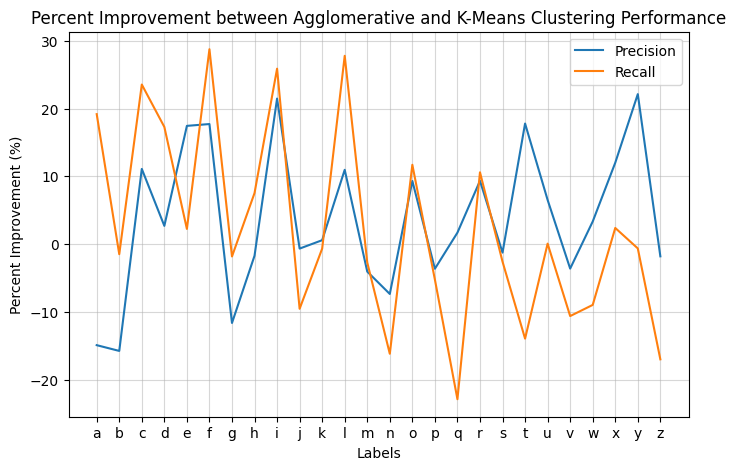

In [137]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_Agg - prec_KMeans)/prec_Agg
diff_recall = (rec_Agg - prec_KMeans)/rec_Agg

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between Agglomerative and K-Means Clustering Performance')
ax.grid(True, alpha=0.5)

As we can see, for the most part the models perform very similarly, but when they deviate the difference in performance is by quite a lot. Let's take the letter 't' for example. In Agglomerative Clustering, we outperform K-Means by about 20% in Precision. This means that we are less likely to call false positives. If we reference the Confusion Matrix from above, we can see that we call a 't' an actual 't' 52 times for Agglomerative, but only 39 times for K-Means. K-Means is more likely to call a 't' an 'i,' which could potentially come back to K-Means not handling variance in letter shape as well as Agglomerative. On the flip-side, we perform much worse in Recall for the letter 'q.' Quite often, the Agglomerative Model mistakes 'q' for a 'g.' This tells us that the model might actually be over-generalizing this cluster, and missing out on the small difference in the two letters. 

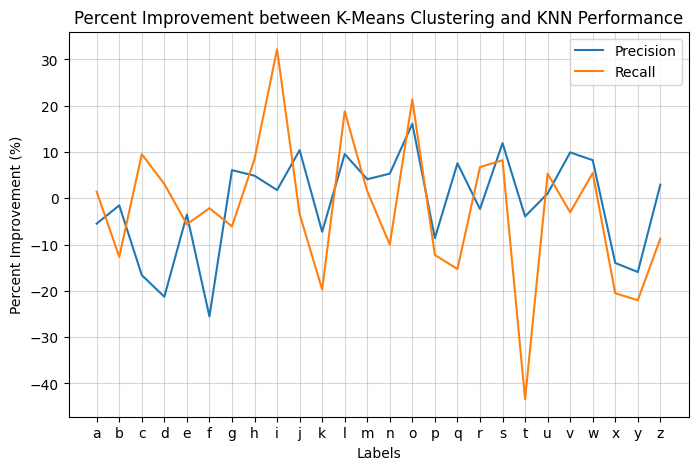

In [138]:
# First we can take the difference between the precision and recall matricies
diff_precision = (prec_KMeans - prec_KNN)/prec_KMeans
diff_recall = (rec_KMeans - prec_KNN)/rec_Agg

# Now we can create our line charts
ax = plt
ax.figure(figsize=(8,5))
ax.plot(alphabet, diff_precision*100, label="Precision")
ax.plot(alphabet, diff_recall*100, label="Recall")
ax.xlabel('Labels')
ax.ylabel('Percent Improvement (%)')
ax.legend()
ax.title('Percent Improvement between K-Means Clustering and KNN Performance')
ax.grid(True, alpha=0.5)

The difference between these two models in terms of Precision isn't that crazy. The worse case is the letter 'f,' where K-Means is 20% worse and often letters like 't' and 'r' get mistaken for 'f.' Again, the clustering method probably is looking more at the shape of the letter and some of the nuances of how each one is written, moreso than KNN. The K-Means model does significantly worse in terms of Recall on the letter 't,' where we see a performance degredation of 40%. Similar to the comment before, we often will mistake 't' for an 'i,' 'f,' or 'l.' These letters are most likley over generalized in their clusters, or again, there is some hidden feature amongst these letters that we're missing that arose from using too many clusters.

Overall, all models performed farily well given the complex dataset and reduced number of sampling. We attained test accuracy scores of 79% for our Agglomerative Clustering Model, 76% for our K-Means Clustering Model, and 76% for our KNN Model. Using a custom hyper-parameter tuning method, we were able to optimize for things like number of clusters, clustering method, and linkage methods for Agglomerative Clustering. For the clustering methods, we opted for the highest number of clusters giving us a high accuracy. Utilizing a higher number of clusters helps in in datasets that have a highly unique feature set, however, it can lead to unexpected clustering as mentioned before where unhidden insights come to the surface. For some applications, like determining where a person is from based on hand-writing alone, this could be helpful, but for our purposes it was actually a degredation at times. For our KNN model, we chose a small leaf size to combat overfitting, along with a modest number of neighbors to be 4, utilizing distance weighting. Distance weighting is helpful for datasets with feature clustering, which the EMNIST dataset contains in terms of where the pixels are location between letters. Both of our Clustering methods performed best overall, but in some places we did see degredation in Precision and Recall. Agglomerative Clustering performed the best, with an accuracy of 80%. 

### **Discussion and Conclusion**

In the end, we achieved our main project goal: To show that we could build basic Unsupervised and Supervised Learning Classifiers on a complex dataset like EMNIST. We were able to successfully clean, explore the data we were working with, train and test basic Classifier models, and attain moderate performance. While performance isn't at 95%+ levels, like some Convolutional Neural Nets might be able to achieve, our Agglomerative Clustering model is able to achieve great results, at 80% accuracy with minimal feature engineering and some hyperparameter tuning. The other two models weren't far behind with accuracies of 76%. All of these models took a matter of seconds to train and test, which is optimal for creating high performance letter recognition models on everyday computers.

Moving forward, I think feature engineering up front may make it easier to process and classify the pixel data down the line. Something like utilizng PCA, or normalizing all the pixels to be either black or white, and nothing in between. This would simplify the dataset, and allow for easier clustering in these models. As mentioned a couple times, this dataset contains both upper- and lower-case letters. For letters like a (a/A) where the variations aren't all too similar, it introduces complexity that these basic models. I might encourage using something like the EMNIST Balanced dataset that has these broken out into different classes, or make it part of the data cleaning process. Finally, this project did not train and test on the full dataset of 88,000 samples. This increased training could help the classifier reach higher performance metrics, or something like partioning the data using a partioning method would help even more. </br>

I think a lot can be taken from this project, and iterated upon to create high performing classifiers. A use case for something like this could be text-to-speech applications, where on the front end we have a camera taking in images of strings, some pre-processing to break those specific letters into smaller images to be classified. These models could also be paired with other models that could help with predicting the letter that's most likely using other context clues, like how close it is to dictionary words and whatnot. The applications for something like this are endless. 